# Parameter (uncertainty) estimates benchmarked with synthetic time series

*Mark Bakker - Delft University of Technology*

The purpose of this notebook is to demonstrate that the parameters estimated by Pastas are unbiased and that the coverage of the estimated uncertainty of the parameters is correct, i.e., the 95% confidence intervals of the estimated parameters contains the true parameter values approximately 95% of the time. 

All examples in this notebook use synthetic data. The true head is simulated with a known response function. The performance of Pastas is evaluated for head series with different kinds of both uncorrelated and correlated errors. The Notebook consists of the following sections:

0. [Generation of the true head series.](#generation-of-synthetic-head-series-the-truth)
1. [Modeling of synthetic heads that contain no errors.](#experiment-0-uncorrelated-errors-no-noise-model)
2. [Modeling of synthetic heads with uncorrelated errors](#experiment-1-correlated-errors-with--no-noise-model)
3. [Modeling of synthetic heads with correlated errors](#experiment-2-correlated-errors-with--with-ar1-noise-model)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gammainc, gammaincinv

import pastas as ps

plt.rcParams["figure.figsize"] = (5, 3)  # default figure size
ps.show_versions()

Pastas version: 1.11.0.dev0
Python version: 3.13.5
NumPy version: 2.1.3
Pandas version: 2.2.3
SciPy version: 1.15.3
Matplotlib version: 3.10.0
Numba version: 0.61.0


The following function generates correlated data with an underlying standard deviation of $\sigma_x$ and a correlation $\rho$.

In [2]:
def generate_correlated_data(N, sigx, rho, seed=1):
    """
    N: length of array of correlated data
    sigx: standard deviation of the correlated data
    rho: correlation coefficient
    seed: seed to be used in random number generation
    """
    sige = np.sqrt(1 - rho**2) * sigx
    np.random.seed(seed)
    e = np.random.normal(0, sige, N - 1)
    x = np.zeros(N)
    x[0] = np.random.normal(0, sigx)  # first point variance sigx
    for j in range(1, len(x)):
        x[j] = rho * x[j - 1] + e[j - 1]
    return x

## Generation of synthetic head series (the truth)

The synthetic head series are generated with a Gamma response function. The response functions are defined below for clarity (alternatively, the response function of Pastas can be used). 

In [3]:
def gamma_tmax(A, n, a, cutoff=0.999):
    """returns time for which step function equals cutoff * A"""
    return gammaincinv(n, cutoff) * a


def gamma_step(A, n, a, cutoff=0.999):
    """
    returns gamma step function starting at t=0 with intervals of delt = 1
    tmax is the time for which the step function reaches cutoff * A
    """
    tmax = gamma_tmax(A, n, a, cutoff)
    t = np.arange(0, tmax, 1)
    s = A * gammainc(n, t / a)
    return s


def gamma_block(A, n, a, cutoff=0.999):
    """returns the gamma block response starting at t=0 with intervals of delt = 1"""
    s = gamma_step(A, n, a, cutoff)
    return np.append(s[0], s[1:] - s[:-1])

The Gamma response function requires three input arguments: A, n and a. The true values of the parameters used in this notebook are given below and the response function is drawn. The response function reflects the response to one unit of recharge during one day. For example, if the units of the recharge are mm/d, then the head response is in mm (in response to 1 mm of recharge). If the units of the recharge are m/d, then the head response is in m (in response to 1 m of recharge). 

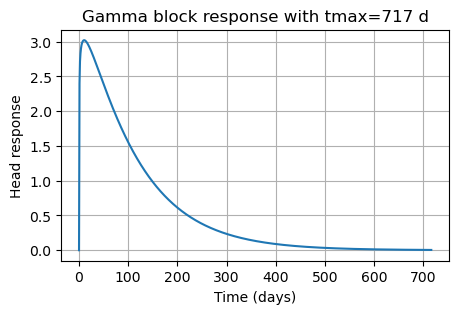

In [4]:
Atrue = 400  # true value of A
ntrue = 1.1  # true value of n
atrue = 100  # true vale of a
dtrue = 20  # base level of heads
ptrue = np.array([Atrue, ntrue, atrue, dtrue])  # array with true parameter values
pnames = ["A", "n", "a", "d"]  # names of parameters
hblock = gamma_block(Atrue, ntrue, atrue)
tmax = gamma_tmax(Atrue, ntrue, atrue)
plt.plot(hblock)
plt.xlabel("Time (days)")
plt.ylabel("Head response")
plt.title(f"Gamma block response with tmax={tmax:.0f} d")
plt.grid()

### Create synthetic observations
Rainfall is used as input series to create a synthetic head series.
The generated head series is purposely not generated with convolution so that it is clear how the head is computed. The computed head at day 1 is the head at the end of day 1 due to rainfall during day 1.

In [5]:
def generate_heads(Atrue, ntrue, atrue, dtrue, rain, yearstart, yearend):
    """yearstart and yearend are strings"""
    step = gamma_block(Atrue, ntrue, atrue)[
        1:
    ]  # start head computation at end of first day
    lenstep = len(step)
    h = dtrue * np.ones(len(rain) + lenstep)
    for i in range(len(rain)):
        h[i : i + lenstep] += rain.iloc[i] * step
    head = pd.Series(index=rain.index, data=h[: len(rain)]).loc[yearstart:yearend]
    return head

Synthetic heads are generated for the period 1990 - 2000. Computations start in 1980 as a warm-up period. The series with daily rainfall starts in 1980.

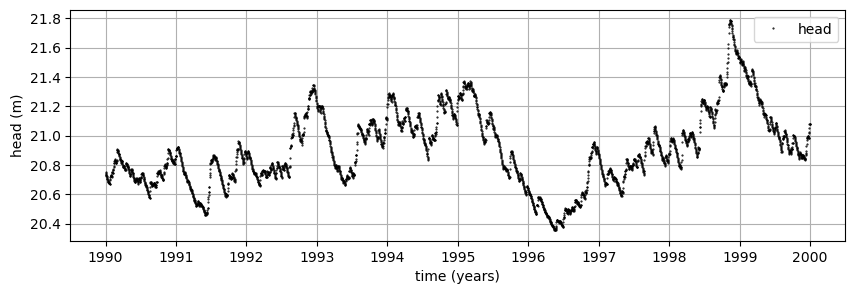

In [7]:
rain = (
    pd.read_csv("../examples/data/rain_260.csv", index_col=0, parse_dates=[0]).squeeze()
    / 1000
)
head = generate_heads(Atrue, ntrue, atrue, dtrue, rain, "1990", "1999")
#
plt.figure(figsize=(10, 3))
plt.plot(head, "k.", label="head", markersize=1)
plt.legend(loc=0)
plt.ylabel("head (m)")
plt.xlabel("time (years)")
plt.grid()

### Synthetic heads that contain no errors.
In this first test, it is demonstrated that Pastas finds the correct parameters back

In [8]:
ml = ps.Model(oseries=head)
sm = ps.StressModel(rain, rfunc=ps.Gamma(cutoff=0.999), name="rain")
ml.add_stressmodel(sm)
ml.solve()

Fit report None                     Fit Statistics
nfev    10                     EVP          100.00
nobs    3652                   R2             1.00
noise   False                  RMSE           0.00
tmin    1990-01-01 00:00:00    AICc     -228430.97
tmax    1999-12-31 00:00:00    BIC      -228406.17
freq    D                      Obj            0.00
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (4 optimized)
            optimal     initial  vary
rain_A        400.0  217.313623  True
rain_n          1.1    1.000000  True
rain_a        100.0   10.000000  True
constant_d     20.0   20.907717  True


### Synthetic heads that contain uncorrelated errors

Uncorrelated errors with $\sigma=0.1$ are added to the synthetic heads.

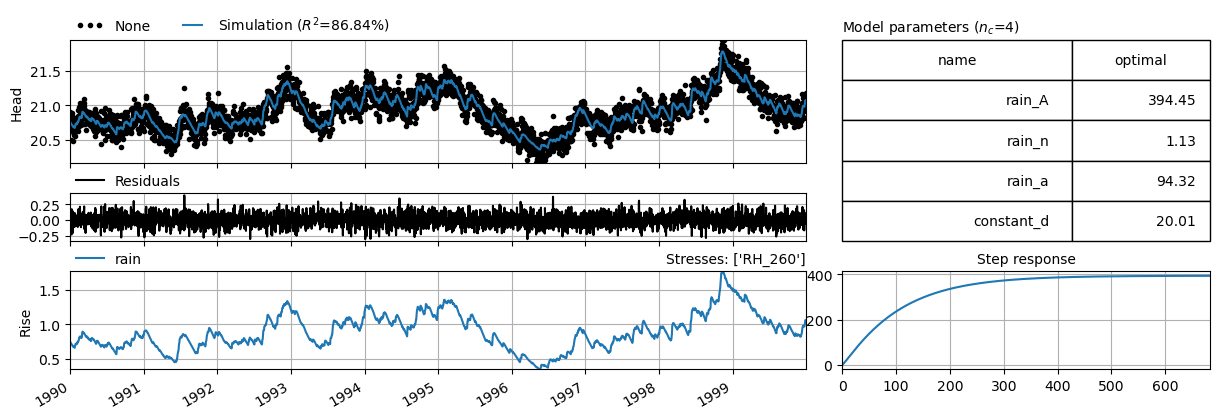

In [9]:
head_error = head + generate_correlated_data(len(head), sigx=0.1, rho=0, seed=1)
ml = ps.Model(oseries=head_error)
sm = ps.StressModel(rain, rfunc=ps.Gamma(cutoff=0.999), name="rain")
ml.add_stressmodel(sm)
ml.solve(report=False)
ml.plots.results(figsize=(12, 4));

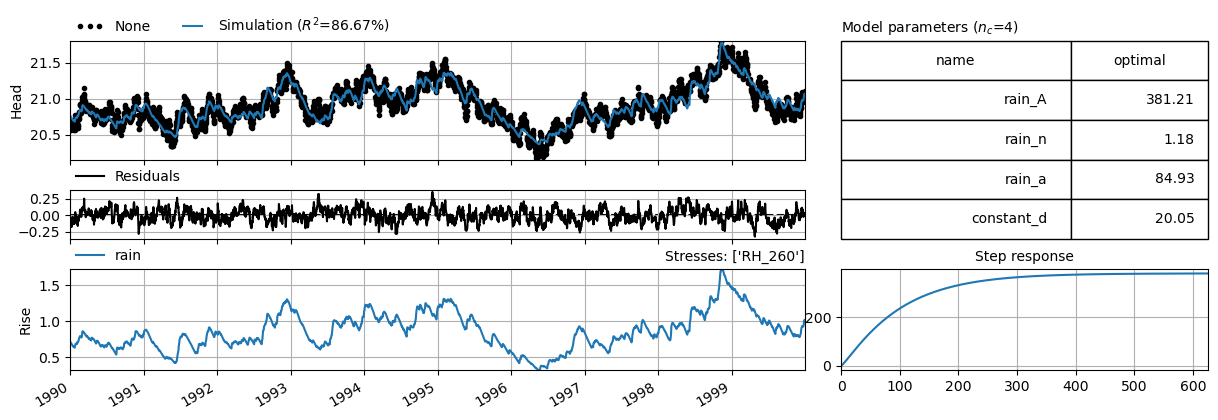

In [10]:
head_error = head + generate_correlated_data(len(head), sigx=0.1, rho=0.9, seed=1)
ml = ps.Model(oseries=head_error)
sm = ps.StressModel(rain, rfunc=ps.Gamma(cutoff=0.999), name="rain")
ml.add_stressmodel(sm)
ml.solve(report=False)
ml.plots.results(figsize=(12, 4));

## Perform experiments to test whether the uncertainty estimate of the parameters is reasonable

In [11]:
def model1(headseries, rain=rain, returnmodel=False):
    """
    Function that creates pastas model for given headseries, rain, a linear
    recharge model and a Gamma response function
    Returns:
    Optimal parameters, their estimated standard error, r-squared
    """
    ml = ps.Model(oseries=headseries)
    sm = ps.StressModel(rain, rfunc=ps.Gamma(cutoff=0.999), name="rain")
    ml.add_stressmodel(sm)
    ml.solve(report=False)
    if returnmodel:
        return ml
    return (
        ml.parameters["optimal"].values,
        ml.parameters["stderr"].values,
        ml.stats.rsq(),
        ml.stats.rmse(),
    )

In [12]:
def model2(headseries, rain=rain, returnmodel=False):
    """
    Function that creates pastas model for given headseries, rain, a linear
    recharge model, a Gamma response function, and an AR1 noise model
    Returns:
    Optimal parameters, their estimated standard error, r-squared
    """
    ml = ps.Model(oseries=headseries)
    sm = ps.StressModel(rain, rfunc=ps.Gamma(cutoff=0.999), name="rain")
    ml.add_stressmodel(sm)
    nm = ps.ArNoiseModel()
    ml.add_noisemodel(nm)
    ml.solve(report=False)
    if returnmodel:
        return ml
    return (
        ml.parameters["optimal"].values,
        ml.parameters["stderr"].values,
        ml.stats.rsq(),
        ml.stats.rmse(),
    )

A numerical experiment is conducted to test whether the Pastas estimates the uncertainty of the parameters correctly. In the experiment, the synthetic head consists of the true head plus an error. Different errors are generated every time. A pastas model is created of the synthetic head series with the introduced error and it is determined whether the true parameters are within the 95% confidence interval of the estimated parameters. The experiment consists of 1000 runs of heads with different random errors. 

In [13]:
def experiment(nexp, nparam, model, ptrue, pnames, sigh=0.1, rho=0):
    """
    nexp: number of times to run the experiment
    nparam: number of parameters to estimate
    model: model function to call (as defined above)
    ptrue: array with true values of the parameters
    sigh: standard deviation of the errors in the synthetic head
    rho: correlation between the errors in the synthetic head
    Returns:
    p: DataFrame with estiamted parameters for each nexp runs
    sig: DataFrame with estimated standard error for each nexp runs
    coverage: DataFrame with 1 row and nparam columns with the coverage
    of each parameter
    """
    head = generate_heads(Atrue, ntrue, atrue, dtrue, rain, "1990", "1999")
    head_errors = [
        head + generate_correlated_data(len(head), sigx=sigh, rho=rho, seed=i)
        for i in range(nexp)
    ]

    p = np.empty((nexp, nparam))
    sig = np.empty((nexp, nparam))
    rsq = np.empty(nexp)
    rmse = np.empty(nexp)
    for i in range(nexp):
        if i % 100 == 0:
            print(".", end="")
        p[i], sig[i], rsq[i], rmse[i] = model(head_errors[i])
    print("\n")

    coverage = (np.abs(p - ptrue) < 1.96 * sig).sum(0)
    p_df = pd.DataFrame(p, columns=pnames)
    sig_df = pd.DataFrame(sig, columns=pnames)
    cov_df = pd.DataFrame(
        coverage[np.newaxis, :] * 100 / nexp,
        columns=pnames,
        index=["coverage percentage"],
    )
    return p_df, sig_df, cov_df, rsq, rmse

### Experiment 0. Uncorrelated errors, no noise model
The coverage is pretty good and close to 95% for all parameters. This shows the standard error estimation in `pastas` is correct when the residuals are uncorrelated.

In [14]:
nexp = 1000  # 1000 runs in the experiments in this notebook

In [15]:
# no correlation between errors, no noise model
sigh = 0.1
rho = 0
p, sig, coverage, rsq, rmse = experiment(
    nexp=nexp, nparam=4, model=model1, ptrue=ptrue, pnames=pnames, sigh=sigh, rho=0
)
coverage  # number of estimates in 95% uncertainty interval (out of 1000)

..........



,A,n,a,d
coverage percentage,95.7,94.2,94.0,95.2


### Experiment 1. Correlated errors with $\rho=0.9$, no noise model
The first set of experiments are for the case that the standard deviation of the error is $\sigma=0.1$ and the correlation between errors from one day to the next is $\phi=0.9$ ($\alpha\approx 9.5$ d). 

The coverage is not very good, as expected. The coverage is low, because the standard error is estimated too low when there is large autocorrelation in the residuals. 

In [16]:
# correlation between errors, no noise model
sigh = 0.1
rho = 0.9
p1, sig1, coverage1, rsq1, rmse1 = experiment(
    nexp=nexp, nparam=4, model=model1, ptrue=ptrue, pnames=pnames, sigh=sigh, rho=rho
)
coverage1

..........



,A,n,a,d
coverage percentage,33.5,42.7,38.9,31.3


In fact, the standard error estimate is approximately 4 times too small for this case. As shown below, when the standard error is 4 times larger, the coverage is reasonable. 

In [17]:
coverage1a = (np.abs(p1.values - ptrue) < 1.96 * (4 * sig1.values)).sum(0)
pd.DataFrame(
    coverage1a[np.newaxis, :] * 100 / nexp,
    columns=pnames,
    index=["coverage percentage"],
)

,A,n,a,d
coverage percentage,93.5,96.9,94.9,92.7


### Experiment 2. Correlated errors with $\rho=0.9$, with AR1 noise model
The coverage is much better now as the AR1 noise model is doing a good job. Only the coverage of the $\alpha$ parameter of the noise model is on the low side. 

In [18]:
# correlation between errors, AR1 noise model
sigh = 0.1
rho = 0.9
alphatrue = -1 / np.log(rho)
ptrue2 = np.hstack((ptrue, alphatrue))
pnames2 = pnames + ["alpha"]
p2, sig2, coverage2, rsq2, rmse2 = experiment(
    nexp=nexp, nparam=5, model=model2, ptrue=ptrue2, pnames=pnames2, sigh=sigh, rho=rho
)
coverage2

..........



,A,n,a,d,alpha
coverage percentage,95.0,94.7,94.8,94.4,91.8


## Parameters are estimated correctly when no noise model is added
In Experiments 1 and 2, the parameters were estimated for synthetic head data with correlated errors in two ways. First, a `pastas` model was used without a noise model and second a `pastas` model as used with a noise model. It was shown that the `pastas` model without a noise model did a poor job in estimating the standard error of the parameters, as expected. But this does not mean that the estimated parameters themselves were biased. On the contrary, the following two graphs demonstrate that the estimated parameters with or without a noise model are essentially similar. The first graph shows a histogram of parameter $A$ with and without the noise model. Note that the two histograms pretty much overlap. The second graph plots the estimated values of $A$ with a noise model vs. the estimated values of $A$ without a noise model. These values plot almost on a straight 45$^\circ$ line, which indicates that the values of $A$ only differ slightly with or without a noise model.

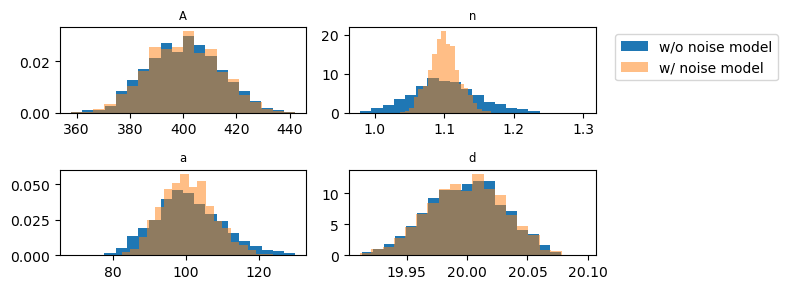

In [19]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(p1.iloc[:, i], bins=20, density=True)
    plt.hist(p2.iloc[:, i], bins=20, density=True, alpha=0.5)
    if i == 1:
        plt.legend(["w/o noise model", "w/ noise model"], bbox_to_anchor=(1.05, 1))
    plt.title(pnames[i], fontsize="small")
plt.tight_layout()

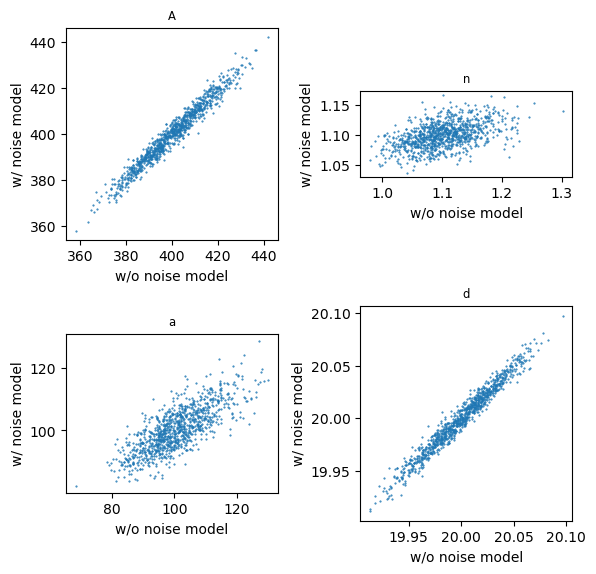

In [20]:
plt.figure(figsize=(6, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1, aspect=1)
    plt.plot(p1.iloc[:, i], p2.iloc[:, i], ".", markersize=1)
    plt.xlabel("w/o noise model")
    plt.ylabel("w/ noise model")
    plt.title(pnames[i], fontsize="small")
plt.tight_layout()

The ultimate test to determine whether parameters estimated without a noise model are not significantly different from parameters estimated with a noise model is to check whether the parameters estimated without a noise model are within the 95% confidence interval of the parameters estimated with the noise model. The estimates values of $n$ are outside the 95% confidence interval more than 300 times out of 1000. That is quite a bit and is an indication that $n$ cannot be estimated very accurately for this dataset.  

In [26]:
print("parameters without noise model within 95% confidence interval with noise model")
print("A, n, a, d")
(np.abs(p1.values - p2.values[:, :-1]) < 1.96 * sig2.values[:, :-1]).sum(0)

parameters without noise model within 95% confidence interval with noise model
A, n, a, d


array([1000,  669,  980, 1000])

## Parameter uncertainty is larger when the correlation factor is larger

The experiments are repeated for the case that the standard deviation of the error is still $\sigma=0.1$ but the correlation between errors from one day to the next is increased to $\phi=0.99$ ($\alpha\approx 99.5$ d). The coverage of the estimated parameter uncertainty is somewhat smaller than 95% when using the AR1 noise model. 

In [22]:
sigh = 0.1
rho = 0.99
p3, sig3, coverage3, rsq3, rmse3 = experiment(
    nexp=nexp, nparam=4, model=model1, ptrue=ptrue, pnames=pnames, sigh=sigh, rho=rho
)
print("coverage without noise model")
display(coverage3)
#
alphatrue = -1 / np.log(rho)
ptrue2 = np.hstack((ptrue, alphatrue))
p4, sig4, coverage4, rsq4, rmse4 = experiment(
    nexp=nexp, nparam=5, model=model2, ptrue=ptrue2, pnames=pnames2, sigh=sigh, rho=rho
)
print("coverage with AR1 noise model")
display(coverage4)

..........

coverage without noise model


,A,n,a,d
coverage percentage,11.8,26.8,16.0,11.4


..........

coverage with AR1 noise model


,A,n,a,d,alpha
coverage percentage,90.8,94.9,91.8,89.1,81.6


### It is sometimes difficult to estimate the parameters when the correlation $\phi$ is very large.
The difficulty lies in the model when no noise model is used. It seems the wrong optimal is sometimes found and it is more difficult to estimate $n$. This requires further investigation. 

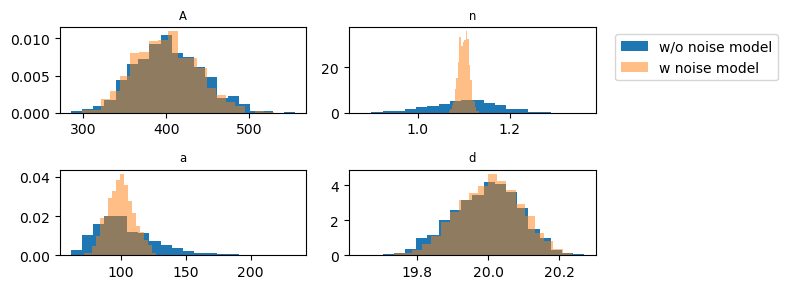

In [23]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(p3.iloc[:, i], bins=20, density=True)
    plt.hist(p4.iloc[:, i], bins=20, density=True, alpha=0.5)
    if i == 1:
        plt.legend(["w/o noise model", "w noise model"], bbox_to_anchor=(1.05, 1))
    plt.title(pnames[i], fontsize="small")
plt.tight_layout()

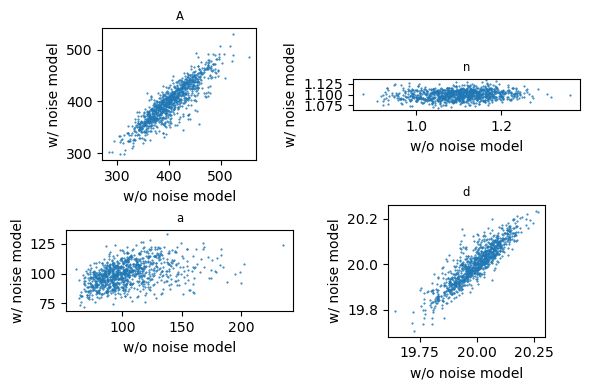

In [24]:
plt.figure(figsize=(6, 4))
for i in range(4):
    plt.subplot(2, 2, i + 1, aspect=1)
    plt.plot(p3.iloc[:, i], p4.iloc[:, i], ".", markersize=1)
    plt.title(pnames[i], fontsize="small")
    plt.xlabel("w/o noise model")
    plt.ylabel("w/ noise model")
plt.tight_layout()

The parameters estimated without a noise model are sometimes significantly different from parameters estimated with a noise model. Below, it is computed how many times the parameters estimated without a noise model are within the 95% confidence interval of the parameters estimated with the noise model. The largest deviation is indeed for the parameters $n$ and $a$ as could also be seen from the graphs above. 

In [25]:
(np.abs(p3.values - p4.values[:, :-1]) < 1.96 * sig4.values[:, :-1]).sum(0)

array([996, 240, 702, 997])